In [124]:
import pandas as pd
import os
def get_csv_data(video_folder_name, fileName):    
    data = pd.read_csv(fileName, sep=';')
    data.columns = ['ID', 'file_name', 'cut_frame']
    file_paths = []
    for entry in data.iloc():
        file_paths.append(video_folder_name + entry['file_name'])
    data['file_path'] = file_paths
    return data

training = get_csv_data('../WS2020_DeepLearning_Videos/Task2_Training_Validation/', '../Task2_Training.csv')
test = get_csv_data('../WS2020_DeepLearning_Videos/Task2_Test/', '../Task2_Test.csv')

training.dropna(inplace=True)
test.dropna(inplace=True)

display(training)
display(test)

,ID,file_name,cut_frame,file_path
0,1,_8Vy3dlHg2w_00132.mp4,63.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
1,2,_8Vy3dlHg2w_00133.mp4,25.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
2,3,_8Vy3dlHg2w_00136.mp4,71.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
3,4,_8Vy3dlHg2w_00139.mp4,35.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
4,5,_8Vy3dlHg2w_00142.mp4,20.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
...,...,...,...,...
295,296,_tigfCJFLZg_00285.mp4,51.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
296,297,_tigfCJFLZg_00286.mp4,130.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
297,298,_tigfCJFLZg_00289.mp4,52.0,../WS2020_DeepLearning_Videos/Task2_Training_V...
298,299,_tigfCJFLZg_00290.mp4,122.0,../WS2020_DeepLearning_Videos/Task2_Training_V...


,ID,file_name,cut_frame,file_path
0,1,_tigfCJFLZg_00293.mp4,131.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
1,2,_tigfCJFLZg_00295.mp4,85.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
2,3,_tigfCJFLZg_00298.mp4,93.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
3,4,_tigfCJFLZg_00299.mp4,138.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
4,5,_tigfCJFLZg_00301.mp4,124.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
...,...,...,...,...
85,86,_tigfCJFLZg_00428.mp4,45.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
86,87,_tigfCJFLZg_00429.mp4,125.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
87,88,_tigfCJFLZg_00430.mp4,49.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...
90,91,_tigfCJFLZg_00435.mp4,44.0,../WS2020_DeepLearning_Videos/Task2_Test/_tigf...


### Problematic Videos handling

In [125]:
# As provided by a team, here are the indexes to drop because of problematic videos

# Control variable for this cell #
drop_problematic = False
#--------------------------------#

faulty_videos = pd.read_csv('../Komplexe_Videos_Task2_Selectierung_Videos.csv', sep=',')
faulty_videos.columns=['file_name', 'problem']

training_index_to_drop = training.merge(faulty_videos, on='file_name').index
test_index_to_drop = test.merge(faulty_videos, on='file_name').index

if drop_problematic:
    training.drop(training_index_to_drop, inplace=True)
    test.drop(test_index_to_drop, inplace=True)
print(training.shape)
print(test.shape)

(299, 4)
(87, 4)


### Assemble helper functions

In [145]:
# Control variable for this cell #
augmentations = ['flip', 'color']
#--------------------------------#

import cv2
import numpy as np
import math
from scipy.ndimage import rotate

def get_augmented_frames(frame, augmentations):
    augmented_frames=[]
    if 'rotate' in augmentations:
        rotated_frame = rotate(frame, 30)
        augmented_frames.append(rotated_frame)
    if 'flip' in augmentations:
        flipped_frame = cv2.flip(frame, 1)
        augmented_frames.append(flipped_frame)
    if 'color' in augmentations:
        colored_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        augmented_frames.append(colored_frame)
    # farben anpassen
    # skalieren
    # zoom
    return augmented_frames

def preprocess_frame(frame, color=cv2.COLOR_BGR2RGB, size=(64,64)):
    frame = cv2.cvtColor(frame, color)
    frame = cv2.resize(frame, size)
    return frame

def get_label_for_frame(frame_number, cut_frame):
    if(frame_number >= cut_frame):
        return 0
    else:
        return 1

def calculate_frame_ratio(totalFrames, cutFrame):
    upperRatio = (totalFrames - cutFrame) / totalFrames
    lowerRatio = cutFrame / totalFrames
    return lowerRatio if upperRatio > lowerRatio else upperRatio

def get_frames_labels(data):
    frames = []
    labels = []
    augmented_frames = []
    augmented_labels = []
    for file in data.iloc():
        file_path = file['file_path']
        cutframe = file['cut_frame']
        
        # Playing video from file:
        cap = cv2.VideoCapture(file['file_path'])
        totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_ratio = calculate_frame_ratio(totalFrames, cutframe)
        minimumFrame = math.ceil(cutframe - (frame_ratio * totalFrames))
        maximumFrame = math.floor(cutframe + (frame_ratio * totalFrames))
        currentFrame = 0
        success, frame = cap.read()

        while(success):
            
            if currentFrame < minimumFrame:
                currentFrame += 1
                success, frame = cap.read()
                continue
            if currentFrame > maximumFrame:
                break
    
            label = get_label_for_frame(currentFrame, cutframe)
            frame = preprocess_frame(frame)
            
            current_augmented_frames = get_augmented_frames(frame, augmentations=augmentations)
            augmented_frames = augmented_frames + current_augmented_frames
            for i in current_augmented_frames:
                augmented_labels.append(label)

            frames.append(frame)
            labels.append(label)

            currentFrame += 1
            success, frame = cap.read()
            
        cap.release()
        cv2.destroyAllWindows()
    return (frames, labels, augmented_frames, augmented_labels)

### Build data

In [146]:
# build data
class_names = ['wet', 'dry']
training_frames, training_labels, augmented_training_frames, augmented_training_labels = get_frames_labels(training)
test_frames, test_labels, augmented_test_frames, augmented_test_labels = get_frames_labels(test)

In [147]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(f'Basic Training frames: {len(training_frames)}')
print(f'Augmented Training frames: {len(augmented_training_frames)}')

all_training_frames = training_frames + augmented_training_frames
all_training_labels = training_labels + augmented_training_labels
print(f'Training frames: {len(all_training_frames)}')

print(f'Basic Test frames: {len(test_frames)}')
print(f'Augmented Test frames: {len(augmented_test_frames)}')

all_test_frames = test_frames + augmented_test_frames
all_test_labels = test_labels + augmented_test_labels
print(f'Test frames: {len(all_test_frames)}')
      
x_train, x_validation, y_train, y_validation = train_test_split(
    np.array(all_training_frames),
    np.array(all_training_labels),
    test_size=0.33,
    random_state=42
)
print(f'Final training frames: {x_train.shape[0]}')
print(f'Final validation frames: {x_validation.shape[0]}')

all_test_frames = np.array(all_test_frames)
all_test_labels = np.array(all_test_labels)


Basic Training frames: 15030
Augmented Training frames: 30060
Training frames: 45090
Basic Test frames: 4596
Augmented Test frames: 9192
Test frames: 13788
Final training frames: 30210
Final validation frames: 14880


### Display example pictures

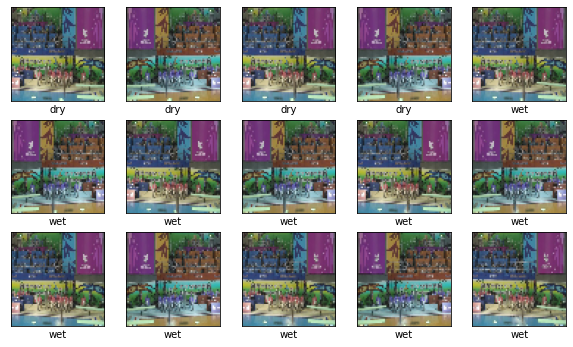

In [148]:
# Control variable for this cell #
first_image = 50
last_image = 65
images = augmented_training_frames
labels = augmented_training_labels
#--------------------------------#

plt.figure(figsize=(10,10))
for i in range(first_image, last_image):
    plt.subplot(5,5,i-first_image+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[augmented_training_labels[i]])
plt.show()

### CNN Modeling Building

In [118]:
from tensorflow.keras import layers, models, regularizers
def build_model():    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64,64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    return model

In [119]:
# This was an attempt to make the model reproducible. Those expressions try to fixate all randomness variables used by TensorFlow and it's ecosystem.
# As of now, the attempt failed.

# # Set a seed value
# seed_value= 12321 
# # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
# import os
# os.environ['PYTHONHASHSEED'] = str(seed_value)
# # 2. Set `python` built-in pseudo-random generator at a fixed value
# import random
# random.seed(seed_value)
# # 3. Set `numpy` pseudo-random generator at a fixed value
# import numpy as np
# np.random.seed(seed_value)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.random.set_seed(seed_value)
# # # 5. Configure a new global `tensorflow` session
# # from keras import backend as K
# # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# # K.set_session(sess)

# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [120]:
model = build_model()
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_validation, y_validation))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 53824)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                3444800   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 3,464,322
Trainable params: 3,464,322
Non-trainable params: 0
____________________________________________

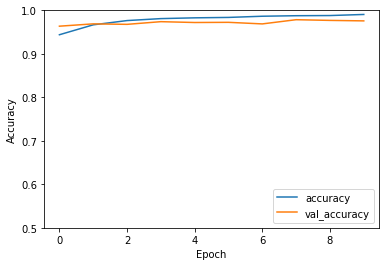

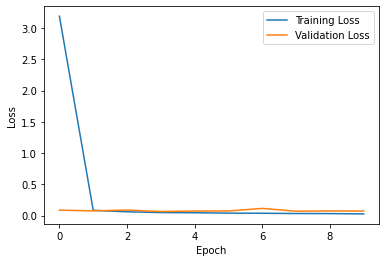

288/288 - 1s - loss: 0.1872 - accuracy: 0.9539
Test Accuracy: 0.9538729190826416, Test Loss: 0.18722543120384216


In [121]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

test_loss, test_acc = model.evaluate(all_test_frames,  all_test_labels, verbose=2)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

### CNN KFold

In [122]:
# Control variable for this cell #
run_kfold = False
#--------------------------------#

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np
if run_kfold:
    num_folds = 5
    # Merge inputs and targets
    x = np.array(training_frames + test_frames)
    y = np.array(training_labels + test_labels)
    # inputs = np.concatenate((input_train, input_test), axis=0)
    # targets = np.concatenate((target_train, target_test), axis=0)
    acc_per_fold = []
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(x, y):

        # Define the model architecture
        model = build_model()

        # Compile the model
        model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model.fit(x[train], y[train],epochs=3)

        # Generate generalization metrics
        scores = model.evaluate(x[test], y[test], verbose=0)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)

        # Increase fold number

        fold_no = fold_no + 1

In [123]:
if run_kfold:
    print(acc_per_fold)
    print(f'Total Score: {np.array(acc_per_fold).mean()}')